# Hopfield 🫠

https://towardsdatascience.com/hopfield-networks-neural-memory-machines-4c94be821073

### Libraries

In [24]:
import utilities as ff
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import PIL
import PIL.Image
import utilities as ff
import tqdm
import random
import pygame

import tensorflow as tf
from tensorflow.keras import activations, layers, optimizers, losses

### Hopfield class

Definition of the Hopfield network class

In [25]:
class Hopfield_Net:  # network class
    # init ialize network variables and memory
    def __init__(self, input, state):

        
        # patterns for network training / retrieval
        self.memory = np.array(input)
        # single vs. multiple memories
        if self.memory.size > 1:
            self.n = self.memory.shape[1]
        else:
            self.n = len(self.memory)
        # network construction
        self.state = np.array(state)  # state vector
        self.weights = np.zeros((self.n, self.n))  # weights vector
        self.energies = []  # container for tracking of energy

        self.pointer = 0
        self.order = list(range(self.n))
        random.shuffle(self.order)
        
        self.is_over=False

    def network_learning(self):  # learn the pattern / patterns
        self.weights = (
            (1 / self.memory.shape[0]) * self.memory.T @ self.memory
        )  # hebbian learning
        np.fill_diagonal(self.weights, 0)

    def update_network_state(self, n_update):  # update network
        for _ in range(n_update): #update n neurons randomly

            self.rand_index = self.order[self.pointer]

            # Compute activation for randomly indexed neuron
            self.index_activation = np.dot(self.weights[self.rand_index, :], self.state)
            # threshold function for binary state change
            if self.index_activation < 0:
                self.state[self.rand_index] = -1
            else:
                self.state[self.rand_index] = 1

        self.pointer = (self.pointer + 1 ) % self.n

    def compute_energy(self):  # compute energy
        self.energy = -0.5 * np.dot(np.dot(self.state.T, self.weights), self.state)
        self.energies.append(self.energy)


### Dataset

Setting parameters.

In [26]:
batch_size = 1
img_height = 100
img_width = 100
color_mode='grayscale'
seed=42
data_dir = pathlib.Path("downloads\CatsDogs")

Downloading the dataset.

In [27]:
ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    color_mode=color_mode,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size,
)

Found 23401 files belonging to 2 classes.


As a big dataset is not needed for this network we focus just on a small sample.

In [28]:
ds=ds.take(100)

We normalize the images to be flattened and with binary values.

In [29]:
normalization_layer = tf.keras.layers.Rescaling(scale=1.0/255, offset=-0.5001)

In [30]:
normalized_ds = ds.map(lambda x, y: (normalization_layer(x), y))

In [31]:
images=[]
labels=np.array([])
for batch in tqdm.tqdm(normalized_ds):
    #sobel=tf.image.sobel_edges(batch[0])
    #sobel_x=np.asarray(sobel[0,:,:,:,1])
    arr = np.squeeze(tf.math.sign(batch[0]))
    images.append(arr)
    labels=np.append(labels,(int(batch[1][0])))
images=np.array(images)
images=images.reshape((-1,10000))

100%|██████████| 100/100 [00:00<00:00, 246.50it/s]


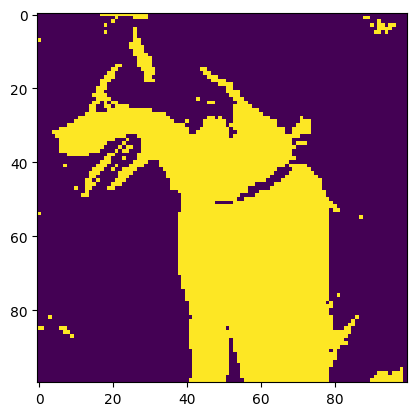

In [123]:
plt.imshow(images[3].reshape((100,100)))
plt.show()

### Testing step by step

Set in memories_list the images to be stored and in test_image the image to be tested.
Then initialize the network.

In [147]:
memories_list=images[:4]
test_index=27
test_image=images[test_index]

In [148]:
#initialize Hopfield object
H_Net = Hopfield_Net(memories_list, test_image)
H_Net.network_learning()

Compute the stable state.

In [149]:
while not H_Net.is_over:
    old_state=np.array(H_Net.state)
    for _ in range(100):
        H_Net.update_network_state(100)
    if np.all(H_Net.state==old_state):
        H_Net.is_over=True

Tested image

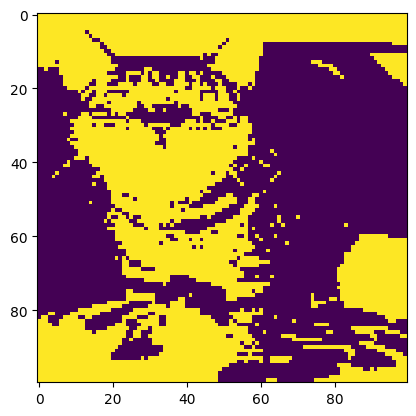

In [150]:
plt.imshow(test_image.reshape((100,100)))
plt.show()

Stable state reached

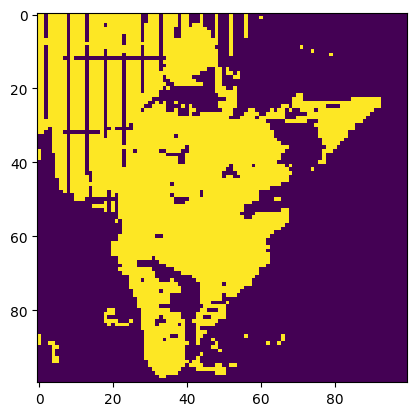

In [151]:
plt.imshow(H_Net.state.reshape((100,100)))
plt.show()

"binary Hopfield networks (BHNs) are prone to ‘spurious’ minima. If memories learned by a BHN are too similar, or if too many pattern vectors are learned, the network risks converging to an in-between memory, some combination of learned patterns; in other words, the network will fail to discriminate between patterns and becomes useless."

Check if it is a spurius state or if the network predicted well.

In [154]:
spurius_state=True
for i, image in enumerate(memories_list):
    if np.all(H_Net.state==image):
        if labels[i]!=labels[test_index]:
            print('error!')
        else:
            print('Predicted well!')
        spurius_state=False

if spurius_state==True:
    print('spurius state!')


Predicted well!


### Experiments

As any presented image to train the Hopfield network define a stable state, this network as always zero training error.

More than that an Hopfield network seems to behave as a non parametric algorithm as the memory footprint increase with the number of patterns stored. The maximum number of pattern storable is bounded by the possible combiations of pixels values, in this case 2 to the power of 10000.

Another problem concern the fact that the network sometimes converge to states different from any pattern stored.


In [117]:
number_of_patterns=10
training_and_test_indexis=random.sample(range(100), number_of_patterns*2)
train_indexis=training_and_test_indexis[:number_of_patterns//2]
test_indexis=training_and_test_indexis[-number_of_patterns//2:]
print(train_indexis,test_indexis)

[23, 95, 22, 40, 38] [35, 4, 36, 62, 78]


In [118]:
memories_list=[images[i] for i in train_indexis]
memories_labels=[labels[i] for i in train_indexis]

In [119]:
n_errors=0
n_spurius_states=0

for index in train_indexis:
    
    #initialize
    H_Net = Hopfield_Net(memories_list, images[index])
    H_Net.network_learning()
    
    #convergence
    while not H_Net.is_over:
        old_state=np.array(H_Net.state)
        for _ in range(100):
            H_Net.update_network_state(100)
        if np.all(H_Net.state==old_state):
            H_Net.is_over=True
    
    #label check
    spurius_state=True
    for i, image in enumerate(memories_list):
        if np.all(H_Net.state==image): #find the image to which had converged
            if memories_labels[i]!=labels[index]:
                n_errors+=1
            spurius_state=False
    if spurius_state:
        n_spurius_states+=1

print(f'Number of errors: {n_errors}')
print(f'Number of spurius states reached: {n_spurius_states}')       
            


Number of errors: 0
Number of spurius states reached: 3


In [120]:
n_errors=0
n_spurius_states=0

for index in test_indexis:
    
    #initialize
    H_Net = Hopfield_Net(memories_list, images[index])
    H_Net.network_learning()
    
    #convergence
    while not H_Net.is_over:
        old_state=np.array(H_Net.state)
        for _ in range(100):
            H_Net.update_network_state(100)
        if np.all(H_Net.state==old_state):
            H_Net.is_over=True
    
    #label check
    spurius_state=True
    for i, image in enumerate(memories_list):
        if np.all(H_Net.state==image): #find the image to which had converged
            if memories_labels[i]!=labels[index]:
                n_errors+=1
            spurius_state=False
    if spurius_state:
        n_spurius_states+=1
        

print(f'Number of errors: {n_errors}')
print(f'Number of spurius states reached: {n_spurius_states}')  

Number of errors: 0
Number of spurius states reached: 5


### Heuristic choice of training

0


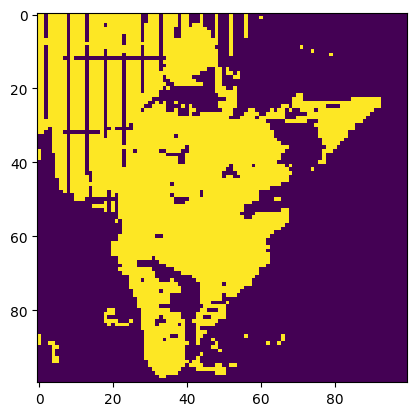

1


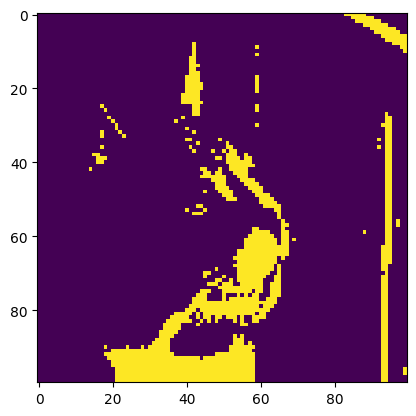

2


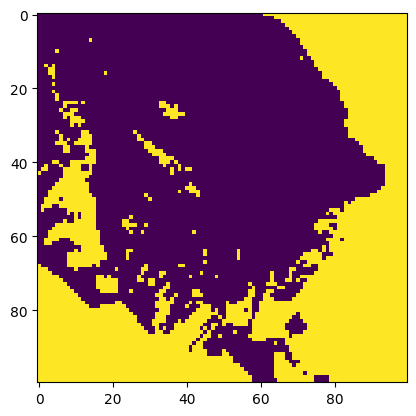

3


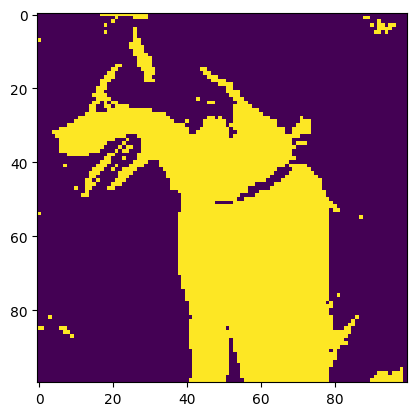

4


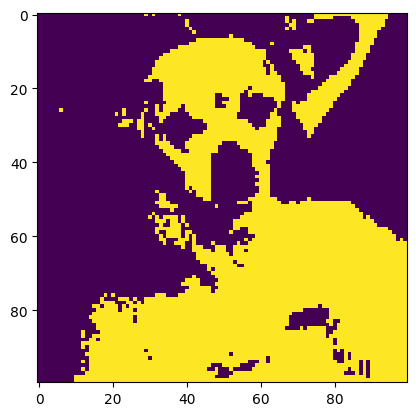

5


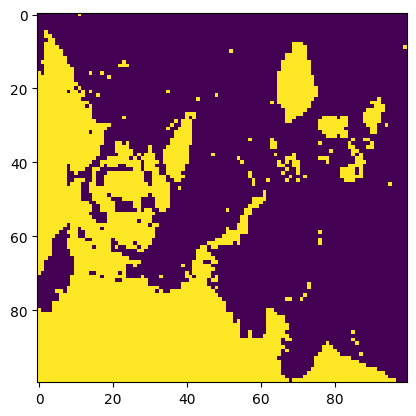

6


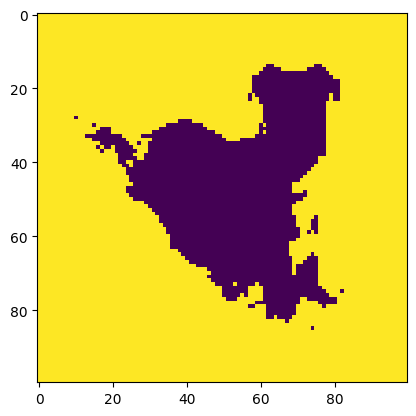

7


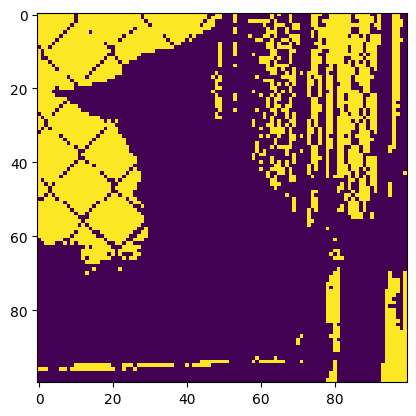

8


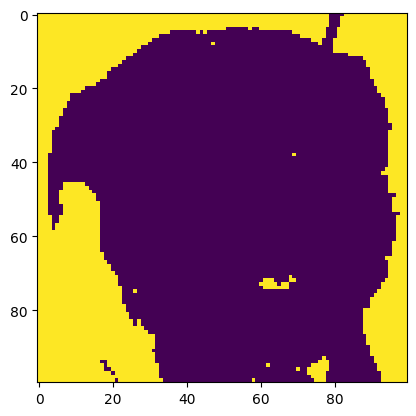

9


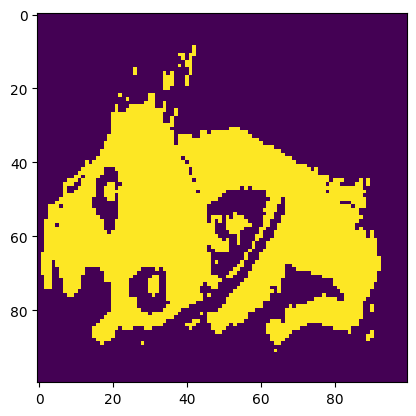

10


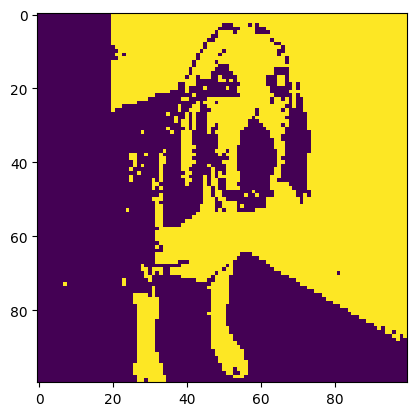

11


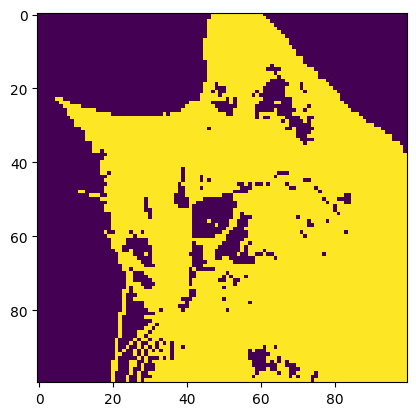

12


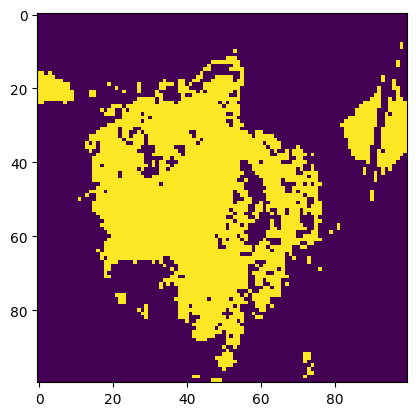

13


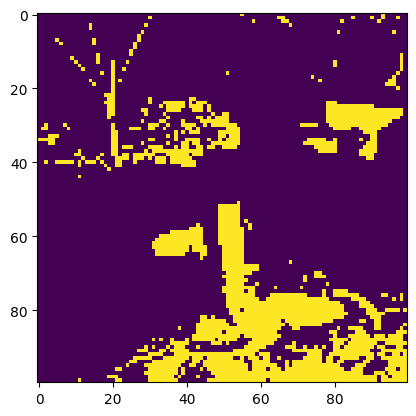

14


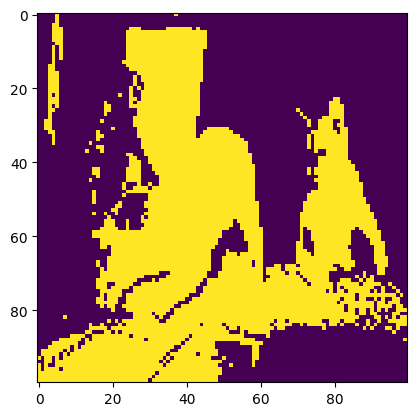

15


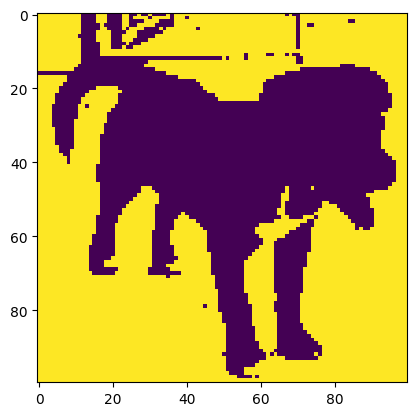

16


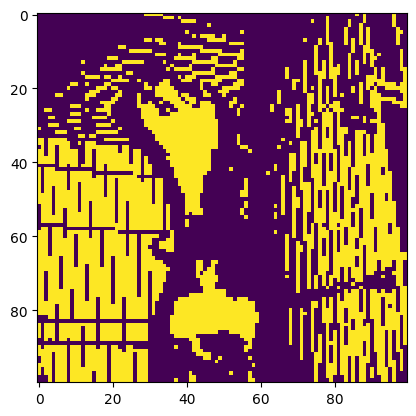

17


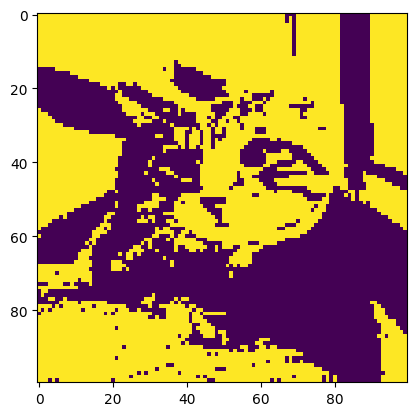

18


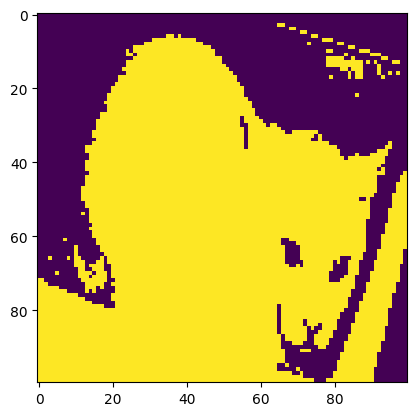

19


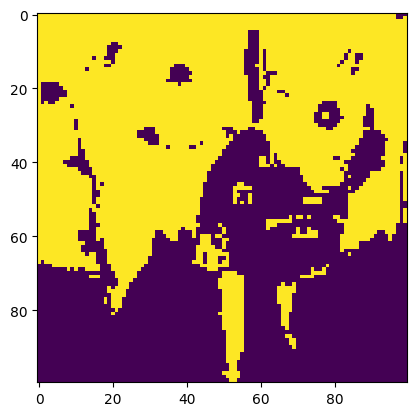

20


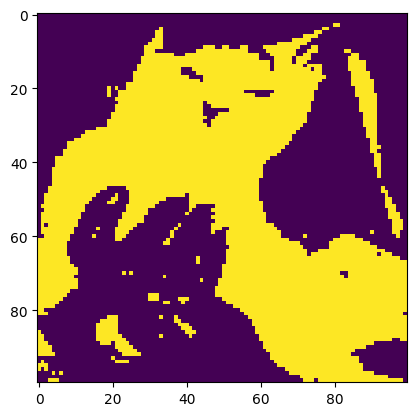

21


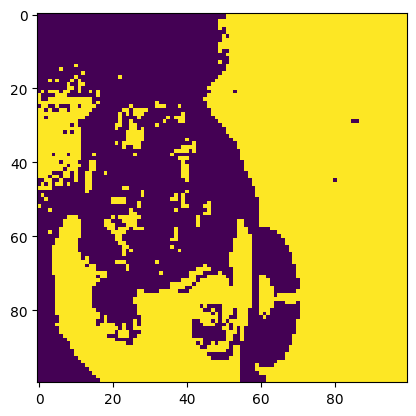

22


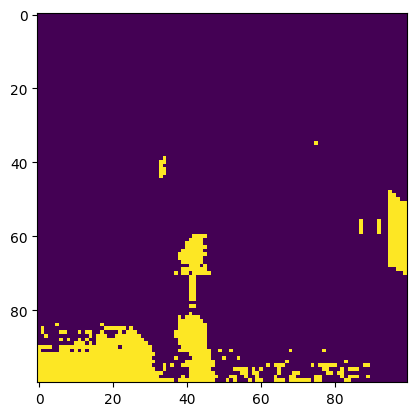

23


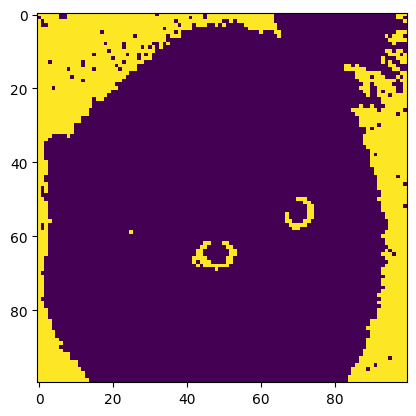

24


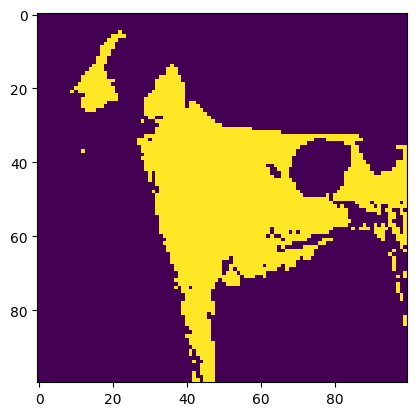

25


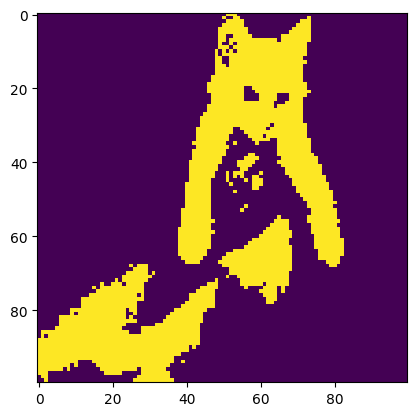

26


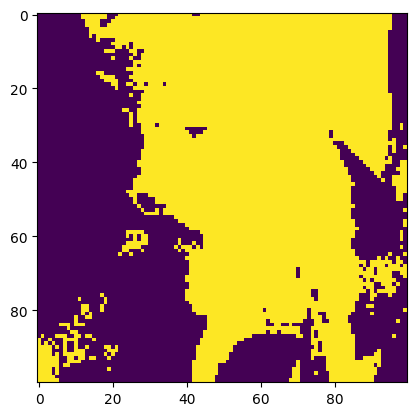

27


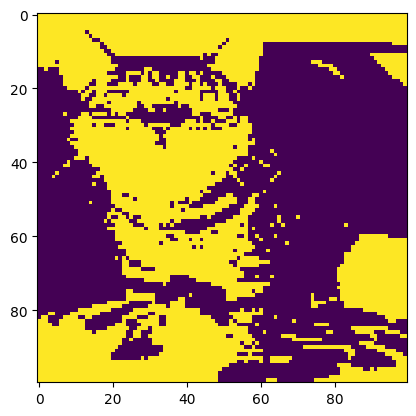

28


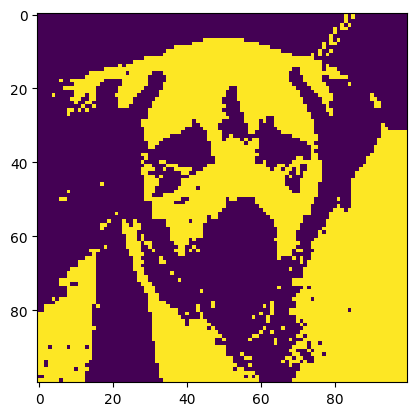

29


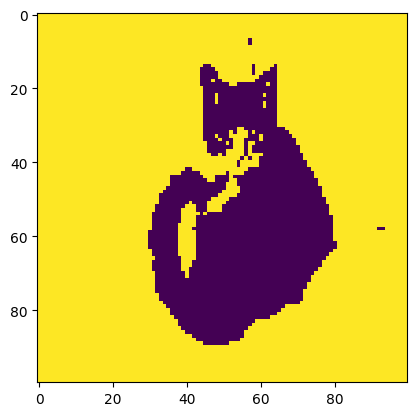

30


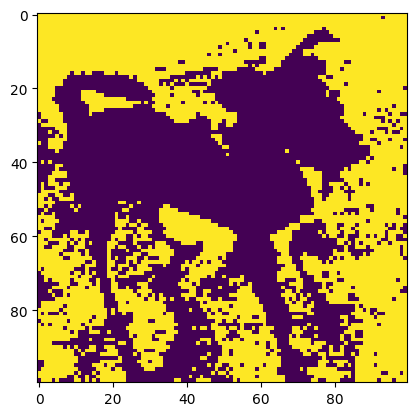

31


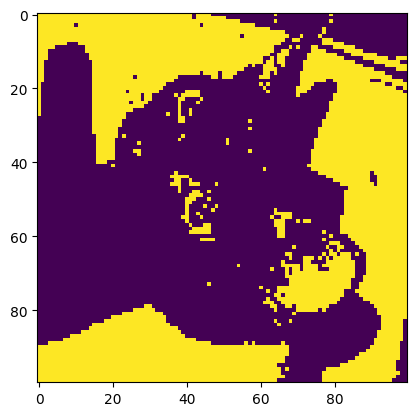

32


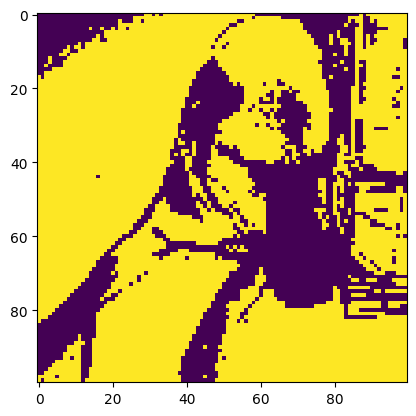

33


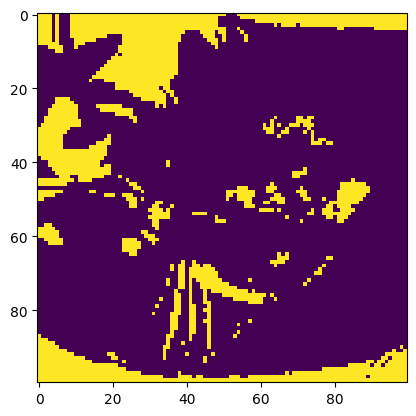

34


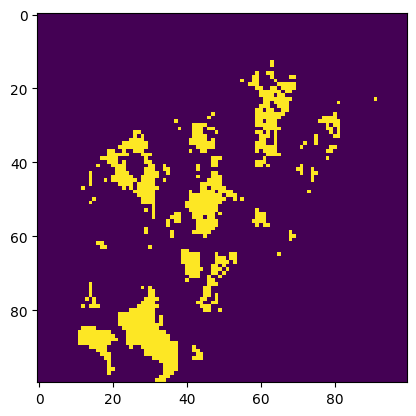

35


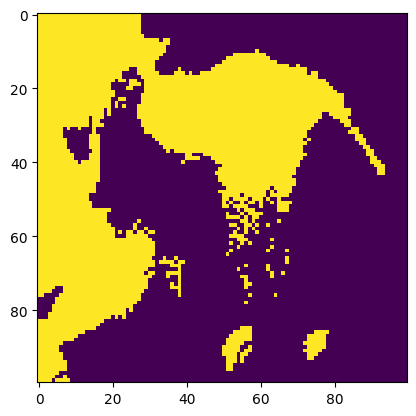

36


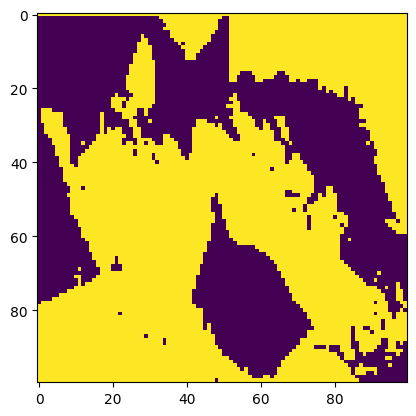

37


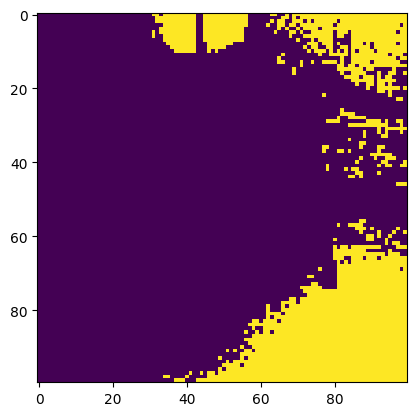

38


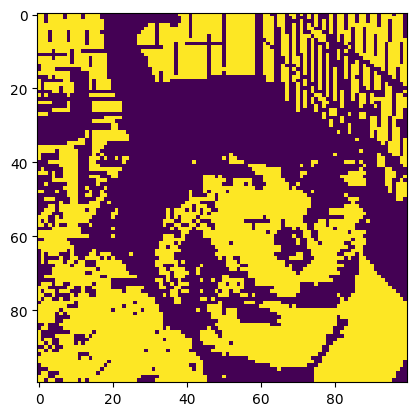

39


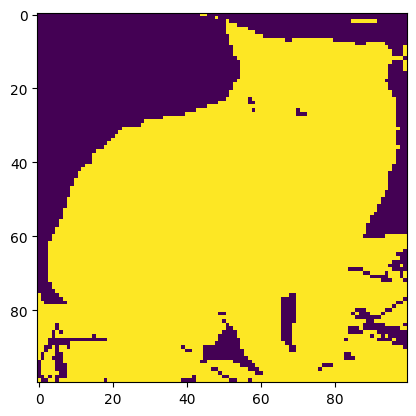

40


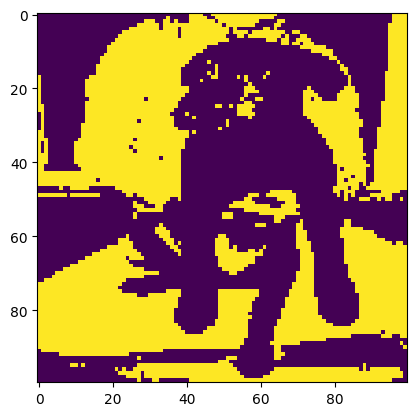

41


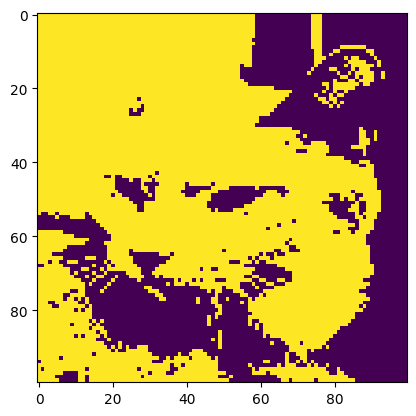

42


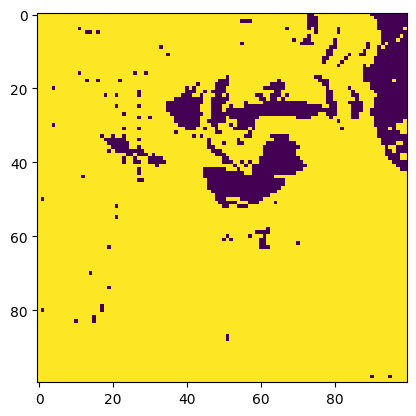

43


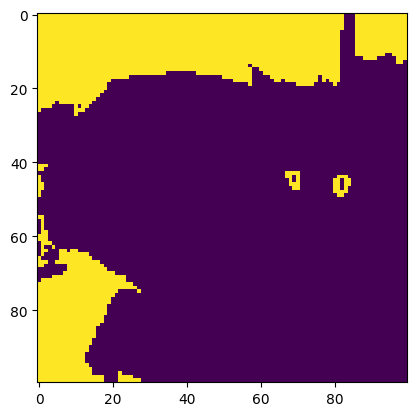

44


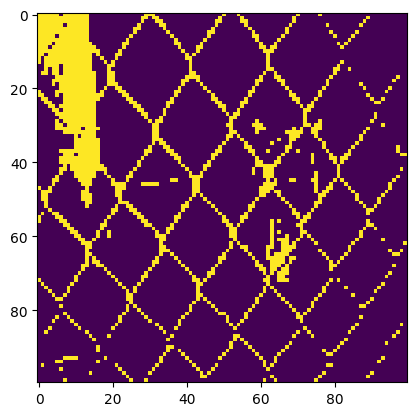

45


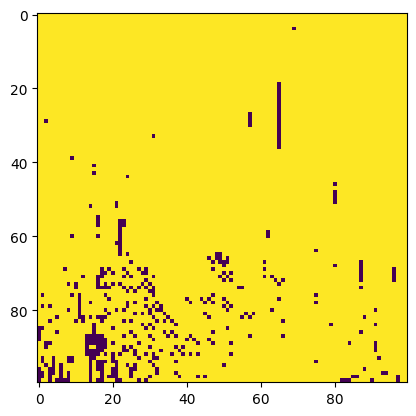

46


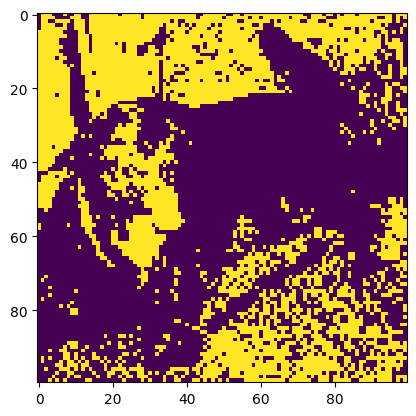

47


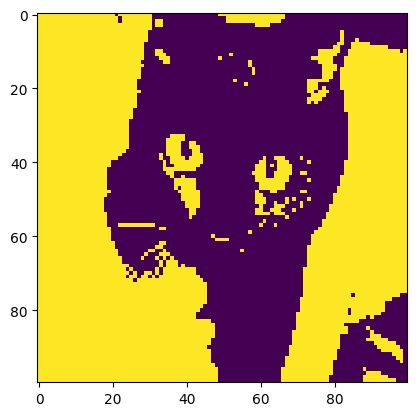

48


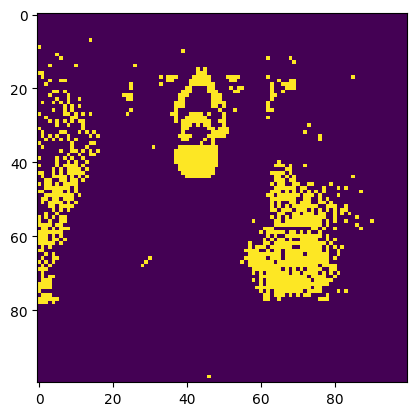

49


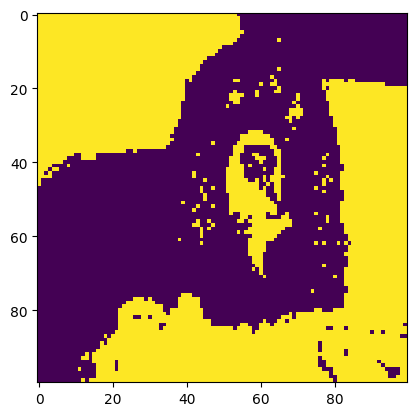

50


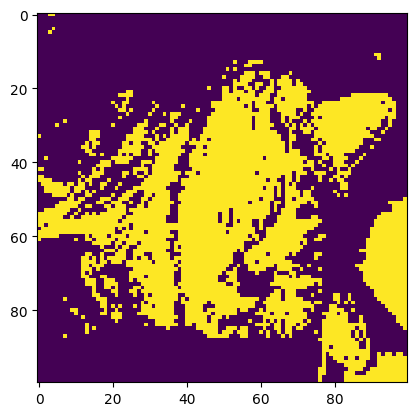

51


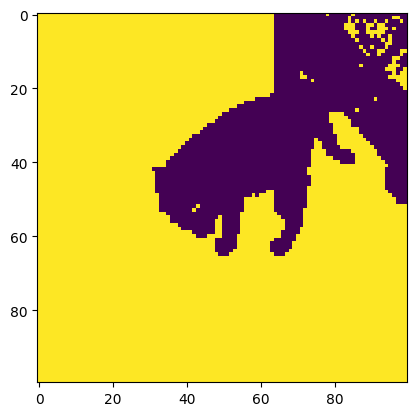

52


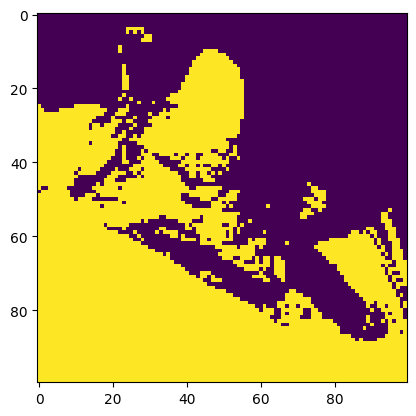

53


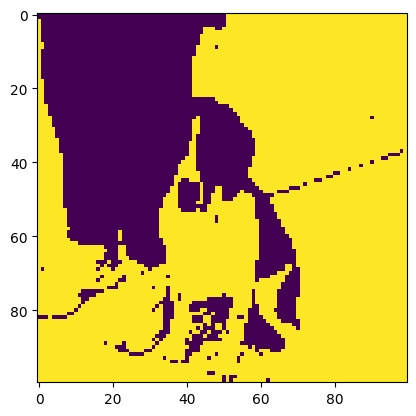

54


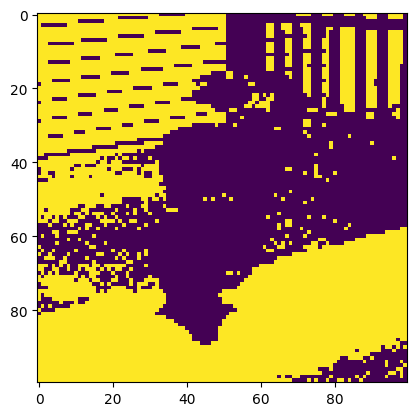

55


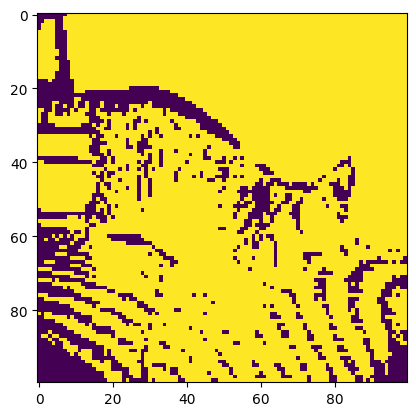

56


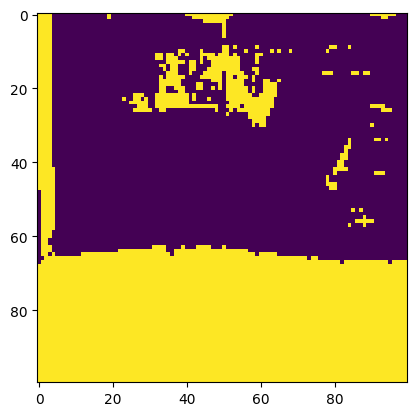

57


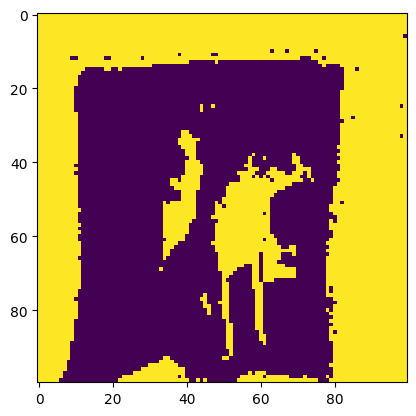

58


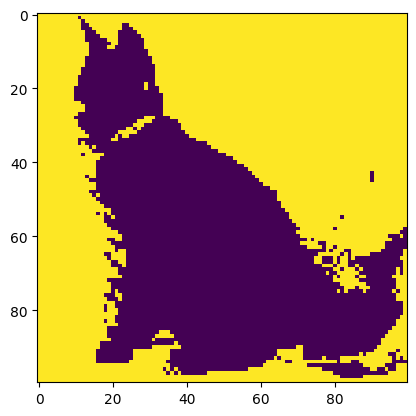

59


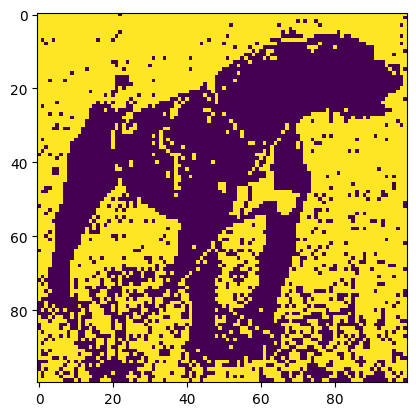

60


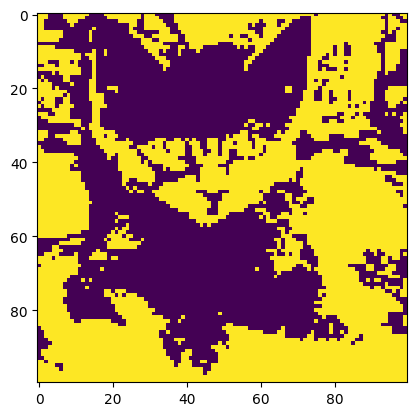

61


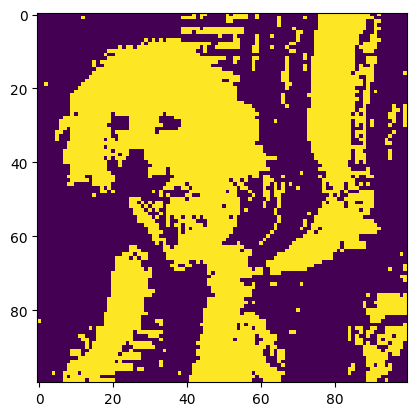

62


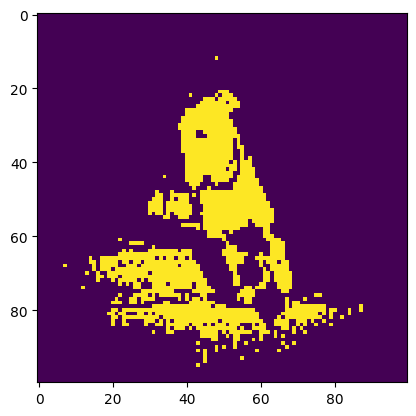

63


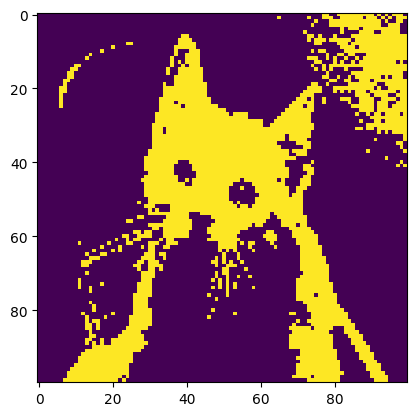

64


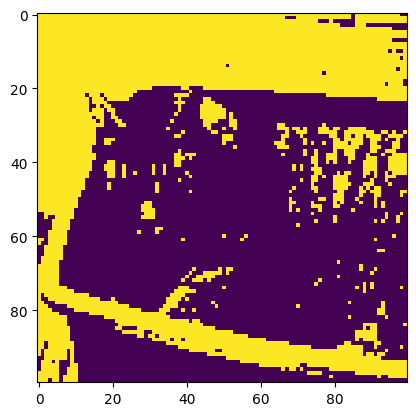

65


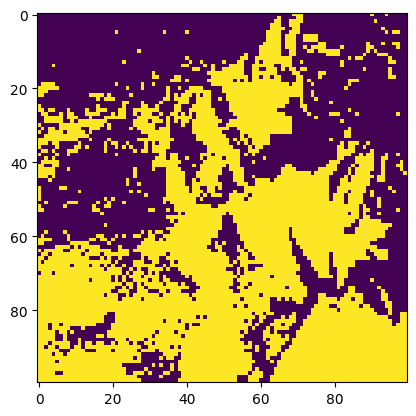

66


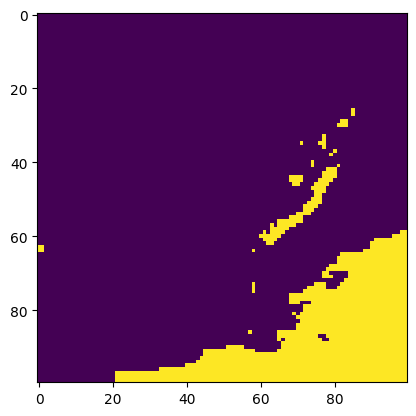

67


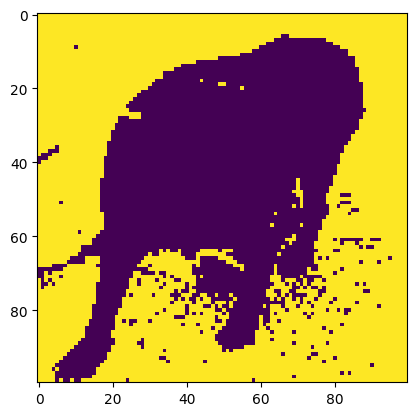

68


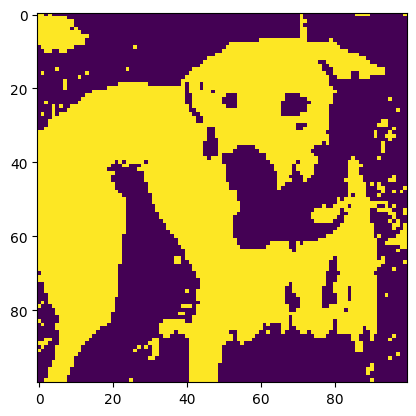

69


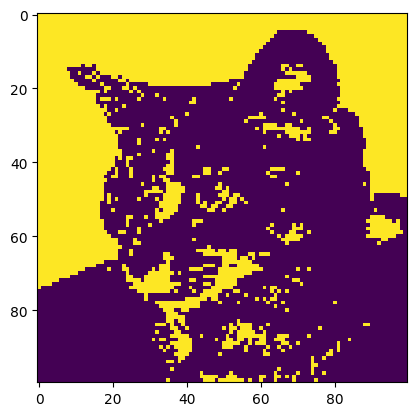

70


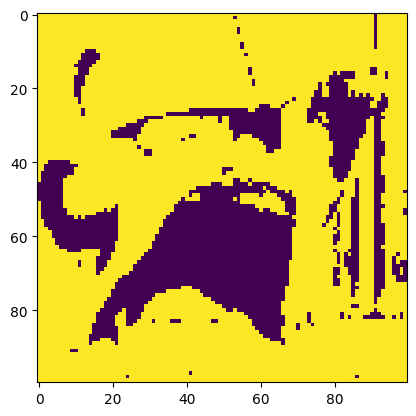

71


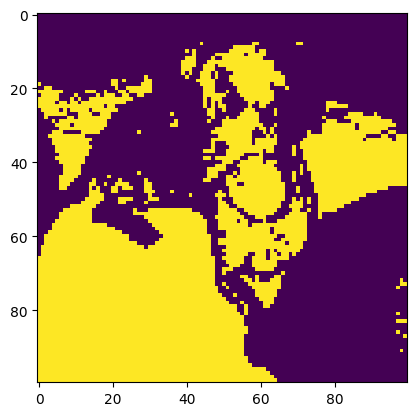

72


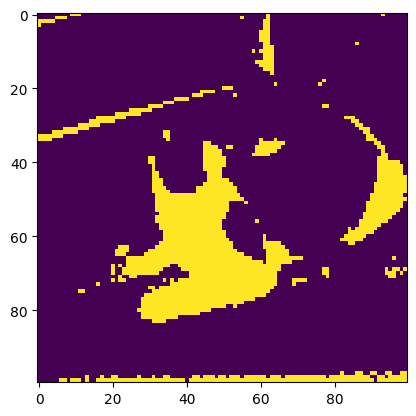

73


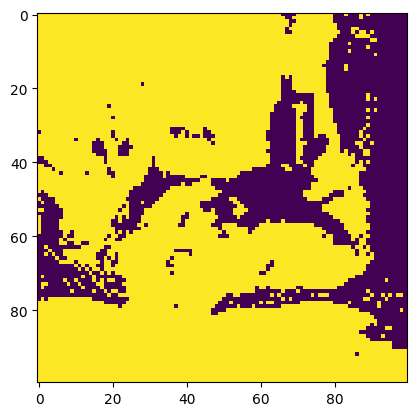

74


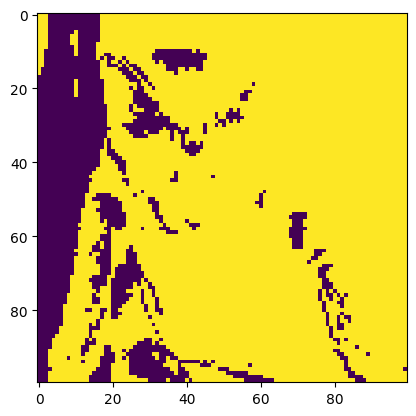

75


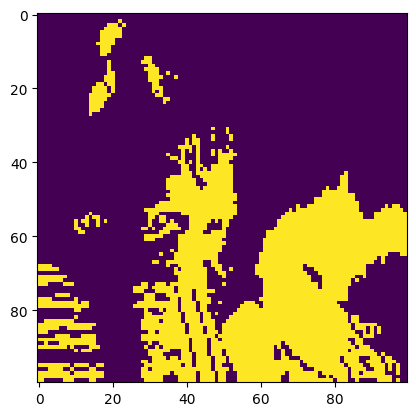

76


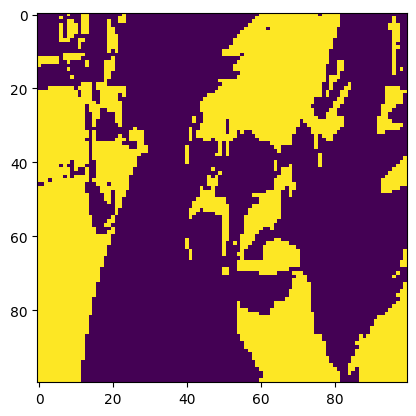

77


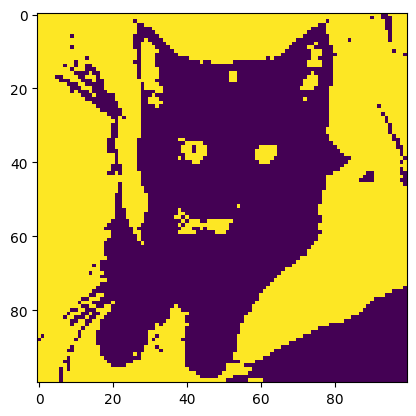

78


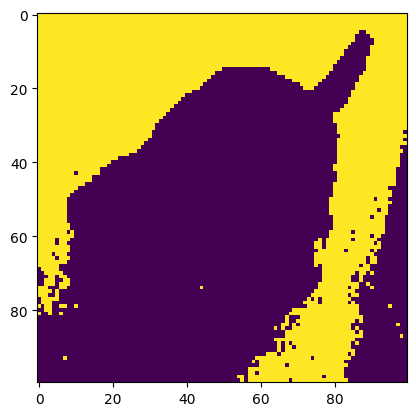

79


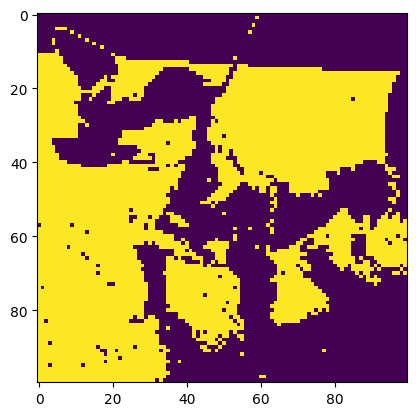

80


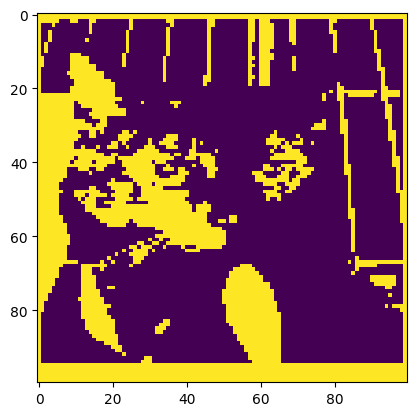

81


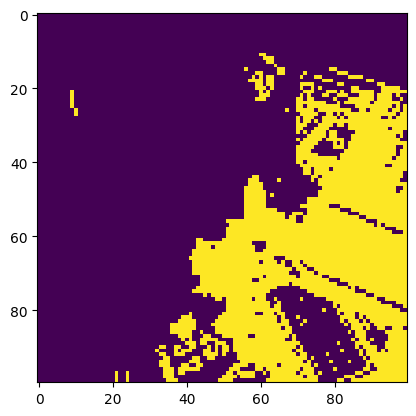

82


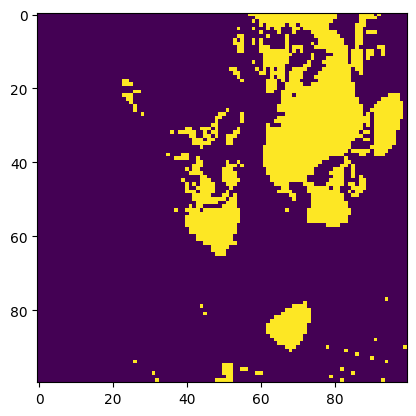

83


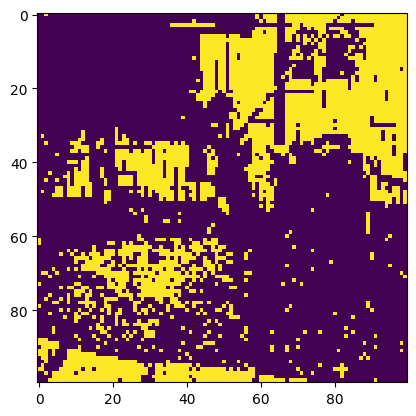

84


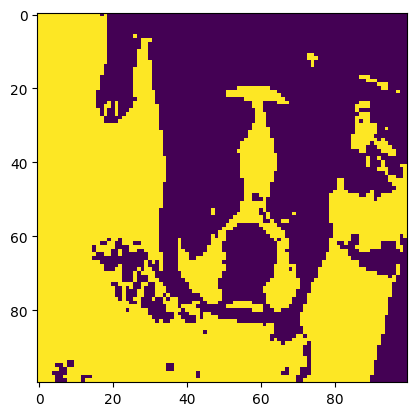

85


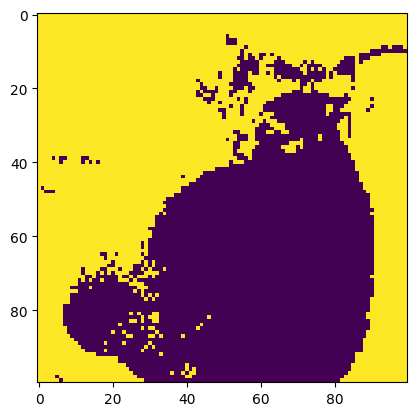

86


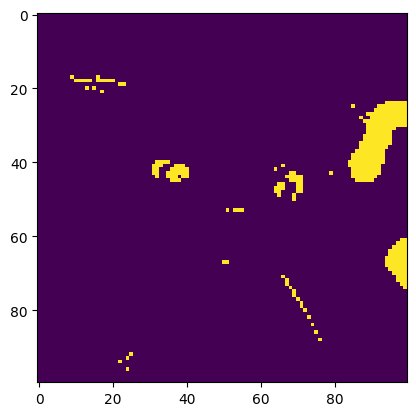

87


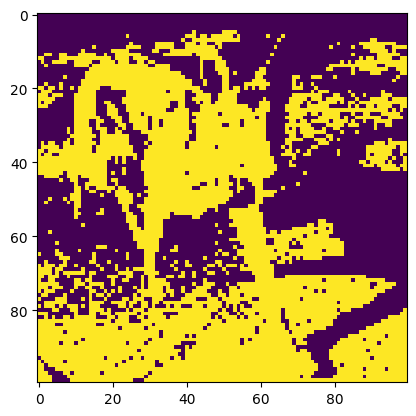

88


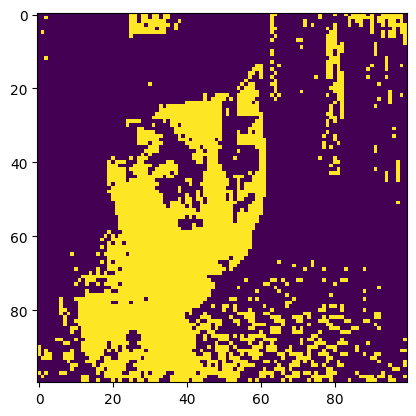

89


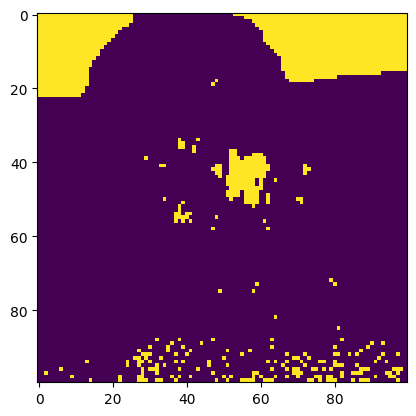

90


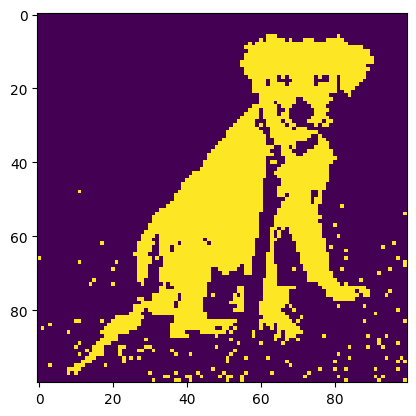

91


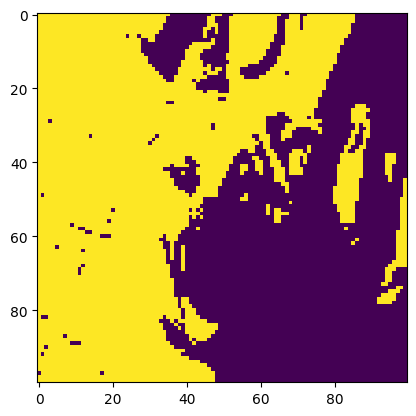

92


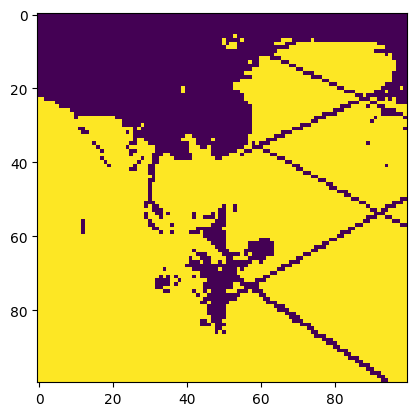

93


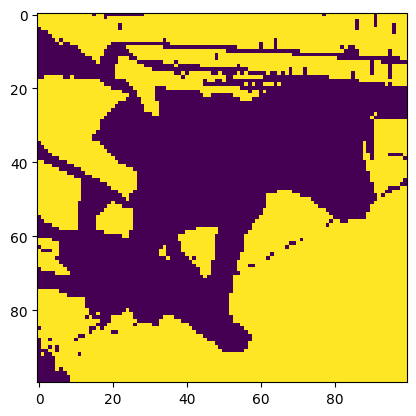

94


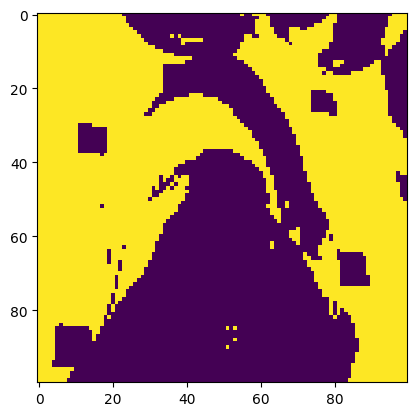

95


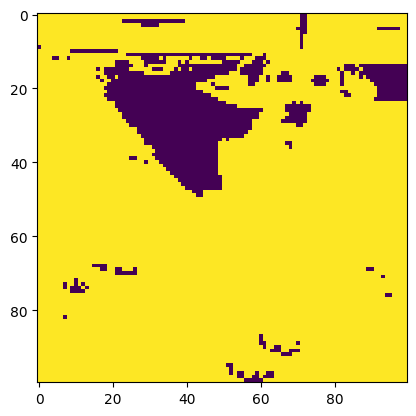

96


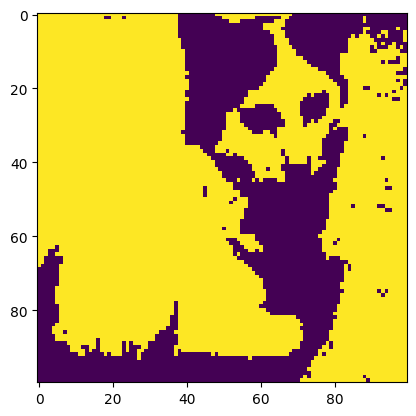

97


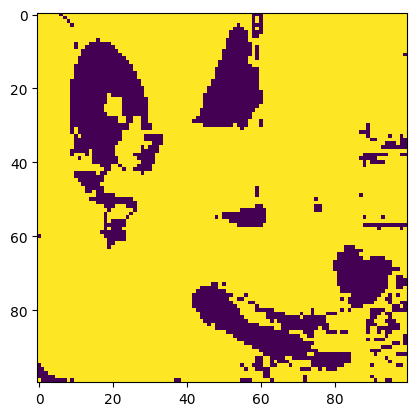

98


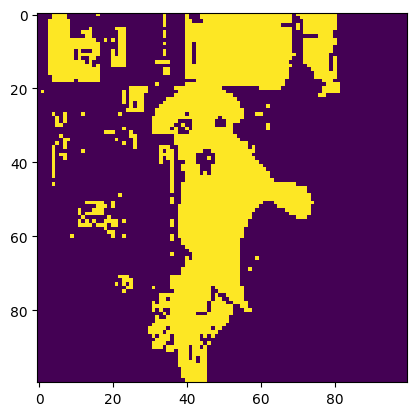

99


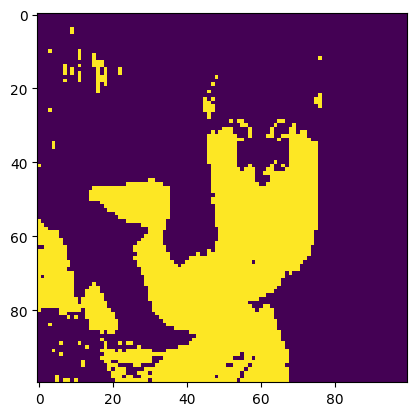

In [15]:
for i in range(len(images)):
    print(i)
    plt.imshow(images[i].reshape((100,100)))
    plt.show()

### Animation

In [155]:
#parameters for pygame

# Draw it all out, updating board each update iteration
cellsize = 5
img_size = 100

pygame.init()  # initialize pygame
# set dimensions of board and cellsize -  28 X 28  ~ special display surface
surface = pygame.display.set_mode((img_size * cellsize, img_size * cellsize))
pygame.display.set_caption("   ")

('display Surface quit',)


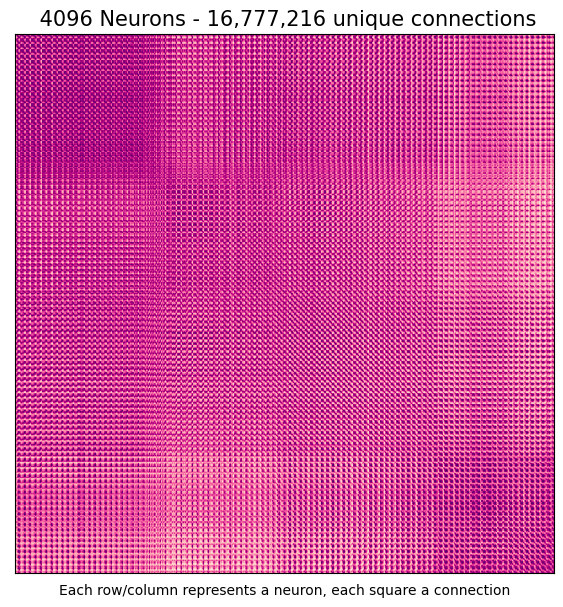

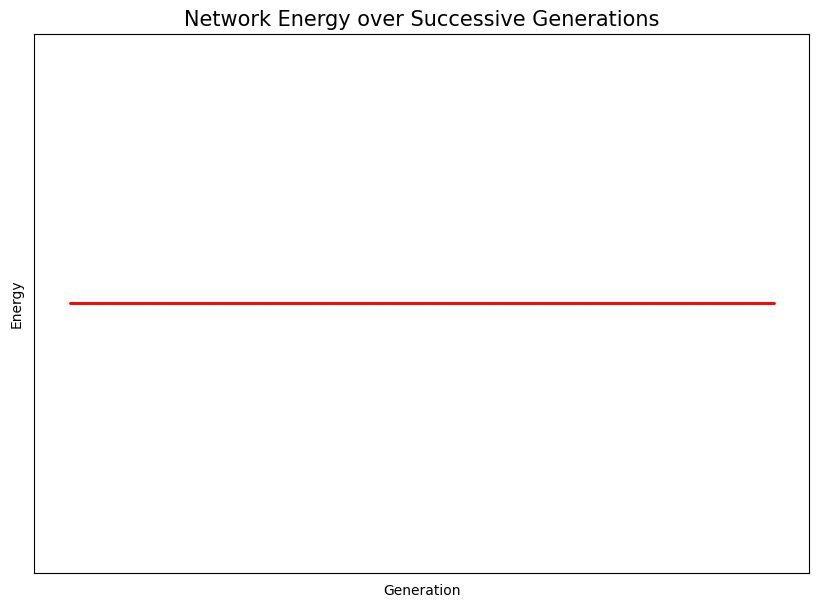

In [156]:
# kill pygame if user exits window
Running = True
# main animation loop
try:
    while Running:
        for event in pygame.event.get():
            pygame.time.wait(1)
            if event.type == pygame.QUIT:
                Running = False

                # plot weights matrix
                plt.figure("weights", figsize=(10, 7))
                plt.imshow(H_Net.weights, cmap="RdPu")  #
                plt.xlabel("Each row/column represents a neuron, each square a connection")

                plt.title(" 4096 Neurons - 16,777,216 unique connections", fontsize=15)
                plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

                # plot energies
                plt.figure("Energy", figsize=(10, 7))
                x = np.arange(len(H_Net.energies))
                plt.scatter(x, np.array(H_Net.energies), s=1, color="red")
                plt.xlabel("Generation")
                plt.ylabel("Energy")
                plt.title("Network Energy over Successive Generations", fontsize=15)
                plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[])

                # quit pygame
                pygame.quit()

        cells = H_Net.state.reshape(img_size, img_size).T

        # fills surface with color
        surface.fill((211, 211, 211))

        # loop through network state array and update colors for each cell
        for r, c in np.ndindex(cells.shape):  # iterates through all cells in cells matrix
            if cells[r, c] == -1:
                col = (135, 206, 250)

            elif cells[r, c] == 1:
                col = (0, 0, 128)

            else:
                col = (255, 140, 0)
            pygame.draw.rect(
                surface, col, (r * cellsize, c * cellsize, cellsize, cellsize)
            )  # draw new cell_

        # update network state
        H_Net.update_network_state(100)
        H_Net.compute_energy()
        pygame.display.update()  # updates display from new .draw in update function
except Exception as inst:
    print(inst.args)


In [ ]:
from scipy.spatial import distance

for i, e in enumerate(images[:2]):
    # print((e.shape))
    # print((H_Net.state.shape))
    # break
    v = distance.hamming(e, H_Net.state)
    # if (e == H_Net.state).all():
    print(v)

0.4883
1.0
0.462
0.4129
0.4269
0.5463
0.6101
0.6318
0.5074
0.6079
